In [1]:
import numpy as np
import os
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import StratifiedKFold as KFold
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import classification_report
from sktime.transformations.panel.rocket import MiniRocketMultivariate as minirocket
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV as LRCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifierCV
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import pickle

In [2]:
# get relative indices
# manually entered via looking at
#https://raw.githubusercontent.com/google/mediapipe/a908d668c730da128dfa8d9f6bd25d519d006692/mediapipe/modules
#/face_geometry/data/canonical_face_model_uv_visualization.png

lower = [76, 77, 90, 180, 85, 16, 315, 404, 320, 307]

upper = [184, 74, 73, 72, 11, 302, 303, 304, 408, 306]

u2 = [61, 185, 40, 39, 37, 0, 267, 269, 270, 409]
l2 = [291, 375, 321, 405, 314, 17, 84, 181, 91, 146]

u3 = [57, 186, 92, 165, 167, 164, 393, 391, 322, 410]
l3 = [287, 273, 335, 406, 313, 18, 83, 182, 106, 43]

combo_indices = lower + upper + u2 + l2 + u3 + l3

In [3]:
opath = "/Users/nraman/Documents/thesis_videos/"
# make sure to get 
subfolders_o = [i for i in os.listdir(opath) if ".mp4" not in i and ".DS_Store" not in i and ".MOV" not in i and ":" in i]
def find_pointfolder(subfolder, path = "/Users/nraman/Documents/thesis_videos/"):
    cur_path = f"{path}{subfolder}"
    # get names of files within the subfolder
    subfiles = os.listdir(f"{path}{subfolder}")
    nps = [i for i in subfiles if ".npy" in i]
    
    if(len(nps) == 1):
        array = np.load(f"{cur_path}/{nps[0]}")
        array = array[:, combo_indices]
        return(array.reshape(array.shape[0], len(combo_indices)*2))

In [4]:
survey_vids = ["ground_2022-01-30 13:10:43.042718", "speech_2022-01-30 13:11:13.294959", "test_speech_2022-01-30 13:17:21.709320", "ground_2022-01-30 13:14:52.838457", "toughspeech_2022-01-21 17:16:31.471513", "speech_2022-01-30 13:16:03.437350", "ground_2022-01-30 13:12:36.560644", "speech_2022-01-21 17:16:49.125882", "speech_2022-01-30 13:16:23.665258", "test_ground_2022-01-30 13:17:11.646731", "speech_2022-01-21 17:15:30.844708", "speech_2022-01-21 17:15:33.359457", "ground_2022-01-30 13:16:43.888130", "test_speech_2022-01-30 13:17:31.804069", "test_speech_2022-01-30 13:16:48.923784", "ground_2022-01-30 13:16:38.857619", "test_speech_2022-01-30 13:17:04.051593", "ground_2022-01-30 13:16:36.326310", "test_speech_2022-01-30 13:17:19.207557", "ground_2022-01-30 13:15:00.402267", "ground_2022-01-30 13:15:02.930923", "test_speech_2022-01-30 13:17:06.582569", "ground_2022-01-30 13:15:13.027508", "test_speech_2022-01-30 13:17:21.709320", "ground_2022-01-30 13:15:15.528437", "test_speech_2022-01-30 13:17:16.677879", "test_speech_2022-01-30 13:17:09.114865", "test_speech_2022-01-30 13:17:01.518291", "ground_2022-01-30 13:15:18.057479", "ground_2022-01-30 13:15:20.557555", "ground_2022-01-30 13:15:23.090369", "ground_2022-01-30 13:15:25.623818", "ground_2022-01-30 13:15:43.281139", "ground_2022-01-30 13:16:28.733014", "test_speech_2022-01-30 13:16:58.982645", "ground_2022-01-30 13:16:31.263864", "test_speech_2022-01-30 13:16:56.453104", "ground_2022-01-30 13:16:33.794845", "test_speech_2022-01-30 13:17:26.738585", "test_speech_2022-01-30 13:16:53.952632", "test_speech_2022-01-30 13:17:29.274213", "ground_2022-01-29 14:30:45.524129", "ground_2022-01-29 14:30:50.555178", "ground_2022-01-29 14:30:53.087316", "speech_2022-01-29 14:29:39.816558", "ground_2022-01-29 14:30:55.618885", "speech_2022-01-29 14:29:42.350774", "speech_2022-01-29 14:29:37.316120", "speech_2022-01-29 14:29:47.412646", "ground_2022-01-29 14:30:58.152935"]

In [5]:
survey_folders = [i for i in survey_vids if i in subfolders_o]
subfolders = [i for i in subfolders_o if i not in survey_folders]

In [6]:
ground_folders = [i for i in subfolders if "ground" in i]
speak_folders = [i for i in subfolders if "ground" not in i]
bad_ones = []

ground_data = []
speak_data = []

for s in speak_folders:
    data = find_pointfolder(s)
    #if(len(data) < 40):
    if(type(data) == np.ndarray):
        speak_data.append(data)
    else:
        bad_ones.append(s)

s_lengths = [s.shape[0] for s in speak_data]
g_lengths = []

for g in ground_folders:
    ar_init = find_pointfolder(g)
#     num_instances = ar_init.shape[0]
#     g_lengths.append(num_instances)
#     choice = np.random.randint(15, 30)
    
#     if(num_instances > 700):
#         splits = 2
#     else:
#         splits = 1
    
    #ground_data.extend(np.array_split(ar_init, splits))
    if(type(ar_init) == np.ndarray):
        ground_data.append(ar_init)
    else:
        bad_ones.append(g)
        
s_lengths = [s.shape[0] for s in speak_data]
g_lengths = [s.shape[0] for s in ground_data]
maxlen = np.max(s_lengths + g_lengths)

In [7]:
# each input is list of arrays (each 2d, of dimension #timepoints x #points*2)--ground corresponds to no speech
# get dataframe of dimension #samples x #features
def timeseries_df(groundlist, speaklist, num_features = len(combo_indices)*2, const = 0, pd_mode = True):
    sz = len(groundlist) + len(speaklist)
    numspeak = len(speaklist)
    
    if(pd_mode == True):
        df = pd.DataFrame(np.zeros([sz, num_features])).astype(object)
    else:
        df = np.zeros((sz, num_features, maxlen))
    
    for j in range(int(sz)):
        for a in range(len(combo_indices)*2):
            if(j < numspeak):
                cur = speaklist[j][:, a]
            elif (j >= numspeak):
                it = j - numspeak
                cur = groundlist[it][:, a]
            
            if(pd_mode == True):
                df.iloc[j, a] = np.pad(cur, (0, maxlen - len(cur)), constant_values = (const))
            else:
                df[a, j] = np.pad(cur, (0, maxlen - len(cur)), constant_values = (const))
    
    true = np.concatenate([np.ones(numspeak), np.zeros(sz - numspeak)])
    
    return df, true

In [8]:
alldata, alltrue = timeseries_df(ground_data, speak_data)
rocket = minirocket(num_kernels = 10000, n_jobs = -1, random_state = 99)
rocket.fit(alldata)

MiniRocketMultivariate(n_jobs=-1, random_state=99)

In [9]:
maxlen

76

In [10]:
X_train = rocket.transform(alldata)
scaler = StandardScaler().fit(X_train)
X_train_transform = X_train
model = LDA(priors = [0.4, 0.6])
model.fit(X_train_transform, alltrue)

LinearDiscriminantAnalysis(priors=[0.4, 0.6])

In [11]:
ground_survey = [i for i in survey_folders if "ground" in i]
speak_survey = [i for i in survey_folders if "ground" not in i]

s_ground_data = []
s_speak_data = []

for s in speak_survey:
    data = find_pointfolder(s)
    #if(len(data) < 40):
    if(type(data) == np.ndarray):
        s_speak_data.append(data)

for g in ground_survey:
    ar_init = find_pointfolder(g)
#     num_instances = ar_init.shape[0]
#     g_lengths.append(num_instances)
#     choice = np.random.randint(15, 30)
    
#     if(num_instances > 700):
#         splits = 2
#     else:
#         splits = 1
    
    #ground_data.extend(np.array_split(ar_init, splits))
    if(type(ar_init) == np.ndarray):
        s_ground_data.append(ar_init)
        
s_s_lengths = [s.shape[0] for s in s_speak_data]
s_g_lengths = [s.shape[0] for s in s_ground_data]
maxlen = np.max(s_s_lengths + s_g_lengths)

In [12]:
survey_X, survey_y = timeseries_df(s_ground_data, s_speak_data)

In [13]:
model.score(rocket.transform(survey_X), survey_y)

0.8

In [14]:
frr = np.sum((model.predict(rocket.transform(survey_X)) - survey_y) == -1)/50

In [15]:
print("False Rejection Rate: " + str(frr * 100) + "%")

False Rejection Rate: 8.0%


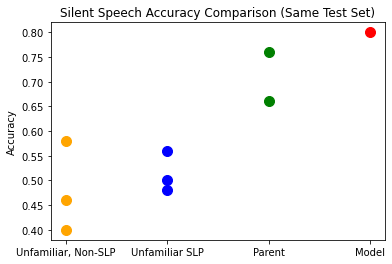

In [21]:
plt.scatter(["Unfamiliar, Non-SLP", "Unfamiliar, Non-SLP", "Unfamiliar, Non-SLP"], np.array([20, 23, 29])/50, c = "orange", s = 100)
plt.scatter(["Unfamiliar SLP", "Unfamiliar SLP", "Unfamiliar SLP"], np.array([24, 25, 28])/50, c = "blue", s = 100)
plt.scatter(["Parent", "Parent"], np.array([33, 38])/50, c = "green", s = 100)
plt.scatter(["Model"], [40/50], c = "red", s = 100)
plt.ylabel("Accuracy")
plt.title("Silent Speech Accuracy Comparison (Same Test Set)")
plt.show()

In [ ]:
rocket.transform(survey_X)

In [ ]:
# filename = 'lda_model.sav'
# pickle.dump(model, open(filename, 'wb'))

In [ ]:
# minirock = 'minirocket_model.sav'
# pickle.dump(rocket, open(minirock, 'wb'))

In [ ]:
# savescaler = 'scaler_model.sav'
# pickle.dump(scaler, open(savescaler, 'wb'))